# Analysis of Silency Maps

## Libraries

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from keras import activations
from tqdm import tqdm

from skimage.transform import resize
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import os
import copy

from shapely.geometry import Polygon, MultiPolygon, box, LineString, MultiLineString
import geopandas as gpd
import cmasher as cmr

import xarray


2025-03-11 12:27:42.614891: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 12:27:44.621767: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 12:27:49.916692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 12:27:49.920122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 12:27:50.685762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = "/leonardo_work/try25_pellegrino/"  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy"
v_test_normalization_factors_std_path  = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy"
v_test_normalization_factors_mean_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy"

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vottignasco_test_image_dates = np.load(v_test_images_dates)
vott_target_test_std         = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean        = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

105
105
105


# Spatial

In [ ]:
piedmont_shp = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/Ambiti_Amministrativi-Province.shp" 

piedmont_bounds = gpd.read_file(piedmont_shp)
piedmont_bounds = piedmont_bounds.to_crs('epsg:4326')
# remove the small enclaved Cuneo area inside Torino province
piedmont_bounds = piedmont_bounds[:-1]

# extract bound, useful for plots
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = piedmont_bounds.total_bounds

piedmont_bounds.boundary.plot()

# Catchment shapefile
catchment = gpd.read_file("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/BAC_01_bacialti.shp") # select GRANA-MAIRA	and VARAITA
catchment = catchment.to_crs('epsg:4326')

# Select only the Grana-Maira catchment
catchment_GM = catchment.loc[catchment.NOME == "GRANA-MAIRA"]
catchment_GM = catchment_GM.reset_index(drop = True)

# Retrieve the borders of the catchment from the shapefile
xmin_clip, ymin_clip, xmax_clip, ymax_clip = catchment_GM.total_bounds
# Extend the borders to include more pixel on the borders

increase = 0.05 # Degrees
#ymin_clip -= increase # not needed
xmin_clip += increase # "+" for subset for pixel included in the mask
xmax_clip += increase
#ymax_clip += increase # not needed

# Define a box around the Region of Interest (ROI)
ROI_box = box(xmin_clip, ymin_clip, xmax_clip , ymax_clip)

ROI_shp = piedmont_bounds.clip(ROI_box)
ROI_shp.boundary.plot()

In [109]:
sample_result_path = "Water_Resources/rise-video/XAI/spatial/results/01_marco_spatial_rise_original_20250310175211/rise_original_spatial_results_all_setup.pkl"

In [110]:
# Loading results
result_st = None
path_to_load_results = os.path.join(work_path, sample_result_path)

with open(path_to_load_results, 'rb') as file:
  result_st = pickle.load(file)

print(result_st)

[{'saliency_maps': array([[[[ 3.84641235e+02,  3.84678192e+02,  3.84712341e+02, ...,
           3.84725189e+02,  3.84700653e+02,  3.84670410e+02],
         [ 3.84641235e+02,  3.84678192e+02,  3.84712341e+02, ...,
           3.84725159e+02,  3.84700653e+02,  3.84670410e+02],
         [ 3.84641235e+02,  3.84678192e+02,  3.84712341e+02, ...,
           3.84725189e+02,  3.84700653e+02,  3.84670410e+02],
         [ 3.84641235e+02,  3.84678192e+02,  3.84712341e+02, ...,
           3.84725189e+02,  3.84700653e+02,  3.84670410e+02],
         [ 3.84641235e+02,  3.84678192e+02,  3.84712341e+02, ...,
           3.84725189e+02,  3.84700592e+02,  3.84670410e+02]],

        [[ 1.70017630e-01,  1.57120153e-01,  1.42188698e-01, ...,
           1.15382403e-01,  1.18701845e-01,  1.23617537e-01],
         [ 1.70017630e-01,  1.57120153e-01,  1.42188698e-01, ...,
           1.15382351e-01,  1.18701845e-01,  1.23617537e-01],
         [ 1.70017630e-01,  1.57120153e-01,  1.42188698e-01, ...,
           1.1538

In [111]:
def normalize_min_max(x, min, max):
    return (x - min) / (max - min)

def plot_frame(frame, shp, cmap="PuBu", title="", figsize = (7,7)):
    
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title)
    ax.imshow(frame, origin="lower", cmap=cmap)
    #shp.boundary.plot(ax = ax, color = "black")
    # y_offset = 104
    # geom = piedmont_bounds.clip(ROI_box).boundary
    # for el in geom:
    #     if isinstance(el, (LineString, MultiLineString)):
    #             print(el)
    #             for line in [el] if isinstance(el, LineString) else el.geoms:
    #                 coords = np.array(line.coords)
    #                 print(coords.shape)
    #                 x_normalized = normalize_min_max(coords[:, 0], xmin_clip, xmax_clip)
    #                 print(x_normalized)
    #                 z_normalized = normalize_min_max(coords[:, 1], ymin_clip, ymax_clip)
                    
    #                 ax.plot(x_normalized*5, z_normalized*8, color='black', alpha=0.7)
    #                 ax.plot(coords[:, 0], coords[:, 1], color='green', alpha=0.7)
    #plt.colorbar()
    plt.tight_layout()

In [112]:
result_st[0].keys()

dict_keys(['saliency_maps', 'errors_insertion', 'auc_insertion', 'errors_deletion', 'auc_deletion', 'parameters_comb', 'execution_times'])

In [122]:
sample_saliency = result_st[22]["saliency_maps"][10][3]
result_st[22]["parameters_comb"]

'h2_w2_p05'

In [123]:
sample_saliency

array([[0.5730809 , 0.56663454, 0.559937  , 0.55484188, 0.5516637 ,
        0.55043644, 0.55259812, 0.55609453],
       [0.56434625, 0.55729866, 0.55002403, 0.54480994, 0.54166585,
        0.54062325, 0.54309034, 0.54717308],
       [0.55817169, 0.55150348, 0.5450421 , 0.54150355, 0.54030365,
        0.54104149, 0.54489005, 0.55028421],
       [0.55188268, 0.54562926, 0.54003698, 0.53822452, 0.53897017,
        0.54144543, 0.54661292, 0.55323988],
       [0.55458242, 0.54930365, 0.54506361, 0.54490858, 0.54735315,
        0.55116916, 0.55719149, 0.56435919]])

In [20]:
meteo_ds = xarray.open_dataset("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/meteo_data_ARPA_GM_clipped.nc") # reading ERA5 file

In [21]:
# ARPA Water Table sensors in Cuneo and Torino Provinces
arpa_wt_sensors = gpd.read_file("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/CN_TO_observed_d_t_c_stations.shp")
arpa_wt_sensors = arpa_wt_sensors.to_crs('epsg:4326')
arpa_wt_sensors = arpa_wt_sensors.loc[arpa_wt_sensors.Munic.isin(["Vottignasco"])]

array([7.57503319])

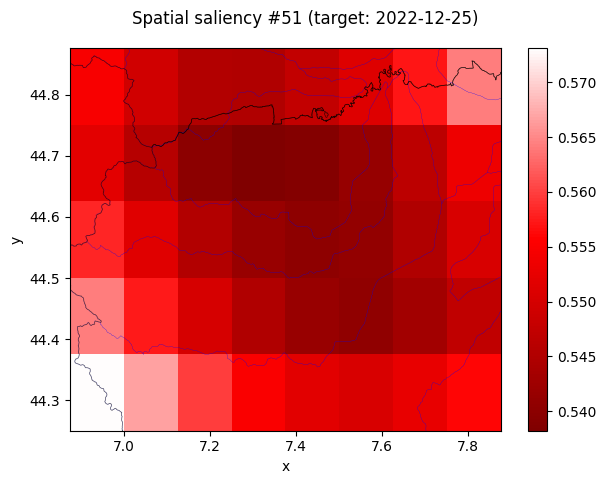

In [57]:
current_instance = 51
data_target = vottignasco_test_dates[current_instance].astype('datetime64[D]')

xarray_saliency = xarray.DataArray(
                data = sample_saliency,
                dims = ["y","x"],
                coords= dict(y = ("y", meteo_ds.coords["lat"].values),
                             x = ("x", meteo_ds.coords["lon"].values))
                )

# Trova i valori minimo e massimo per la colorbar
vmin = np.min(xarray_saliency)
vmax = np.max(xarray_saliency)
# vmin = np.min(vott_norm_sm_all_instances)
# vmax = np.max(vott_norm_sm_all_instances)

fig, ax = plt.subplots()
catchment.boundary.plot(ax = ax,color = "Blue", linewidth = 0.1, alpha = 1)
piedmont_bounds.boundary.plot(ax = ax,color = 'Black', linewidth = 0.5, alpha = 0.6)
xarray_saliency.plot(ax = ax, cmap=cmr.get_sub_cmap('seismic', 0.5, 1).reversed(), vmin=vmin, vmax=vmax)
#plot(ax = ax,color = 'yellow', linewidth = 0.5, alpha = 1)
# dtm_piemonte_clipped.plot(ax = ax, cmap='gray_r', alpha = 0.15)

fig.suptitle(f'Spatial saliency #{current_instance} (target: {data_target[0]})', fontsize=12)
plt.tight_layout()

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_xlabel(None)
#ax.set_ylabel(None)

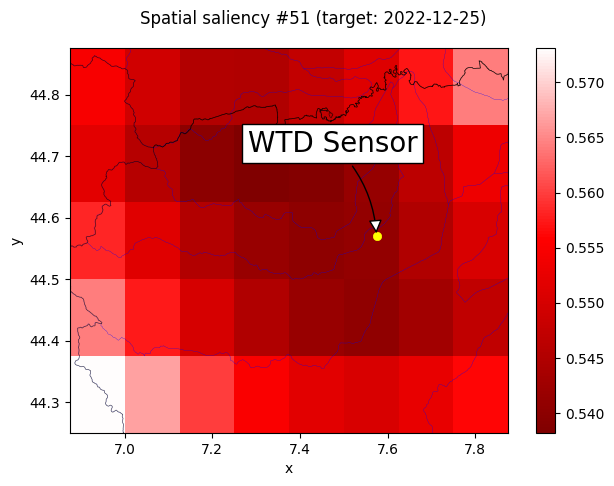

In [56]:
current_instance = 51
data_target = vottignasco_test_dates[current_instance].astype('datetime64[D]')

xarray_saliency = xarray.DataArray(
                data = sample_saliency,
                dims = ["y","x"],
                coords= dict(y = ("y", meteo_ds.coords["lat"].values),
                             x = ("x", meteo_ds.coords["lon"].values))
                )

# Trova i valori minimo e massimo per la colorbar
vmin = np.min(xarray_saliency)
vmax = np.max(xarray_saliency)
# vmin = np.min(vott_norm_sm_all_instances)
# vmax = np.max(vott_norm_sm_all_instances)

fig, ax = plt.subplots()
catchment.boundary.plot(ax = ax,color = "Blue", linewidth = 0.1, alpha = 1)
piedmont_bounds.boundary.plot(ax = ax,color = 'Black', linewidth = 0.5, alpha = 0.6)
xarray_saliency.plot(ax = ax, cmap=cmr.get_sub_cmap('seismic', 0.5, 1).reversed(), vmin=vmin, vmax=vmax)
arpa_wt_sensors.plot(ax = ax,color = 'yellow', linewidth = 0.5, alpha = 1)
# dtm_piemonte_clipped.plot(ax = ax, cmap='gray_r', alpha = 0.15)

ann = ax.annotate("WTD Sensor",
                  xy=(arpa_wt_sensors.geometry.x.values,
                      arpa_wt_sensors.geometry.y.values), xycoords='data',
                  xytext=(arpa_wt_sensors.geometry.x.values - 0.1,
                          arpa_wt_sensors.geometry.y.values + 0.15), textcoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"))

fig.suptitle(f'Spatial saliency #{current_instance} (target: {data_target[0]})', fontsize=12)
plt.tight_layout()

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_xlabel(None)
#ax.set_ylabel(None)

## Temporal 

In [59]:
import sys 

# Aggiungi il percorso della cartella XAI (risali di tre livelli dal notebook)
xai_path = os.path.abspath(os.path.join('..', '..', '..'))
sys.path.append(xai_path)

In [60]:
from common import plots

import importlib

# Forza il reload del modulo
importlib.reload(plots)

<module 'common.plots' from '/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/common/plots.py'>

In [3]:
sample_temp_result_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/temporal/results/01_marco_temporal_rise_original_20250310173717/rise_temporal_original_result_setup_l_12_p_5.pkl"

In [4]:
import pickle

# Load della lista results
with open(sample_temp_result_path, 'rb') as file:
  result_rise_temporal = pickle.load(file)

In [5]:
result_rise_temporal.keys()

dict_keys(['saliency_vectors', 'errors_insertion', 'auc_insertion', 'errors_deletion', 'auc_deletion', 'parameters_comb', 'execution_times'])

In [6]:
result_rise_temporal["saliency_vectors"][0][0].shape

(104,)

In [283]:
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable 
from matplotlib.collections import LineCollection

# Funzione per determinare la stagione in base al giorno dell'anno
def get_season(day):
    spring = np.arange(80, 172)
    summer = np.arange(172, 264)
    fall = np.arange(264, 355)

    if day in spring:
        return 'Spring'
    elif day in summer:
        return 'Summer'
    elif day in fall:
        return 'Autumn'
    else:
        return 'Winter'

season_colors = {
    'Winter': 'darkslategray',#'#AEC6CF',  # Azzurro chiaro
    'Spring': 'darkolivegreen', #'#77DD77',  # Verde menta
    'Summer': 'olivedrab', #'#FFD700',  # Giallo dorato
    'Autumn': 'cadetblue', #'#FF8C00'   # Arancione scuro
}

def plot_saliency_vector(saliency_vector, test_dates, test_images_dates, instance_number, ylab, mode="standard", input_size=104, reverse_cbar = "False"):
    
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]
    
    #Create Barplot:
    data_color = [(x-saliency_vector.min()) / (saliency_vector.max()-saliency_vector.min()) for x in saliency_vector] #see the difference here
    my_cmap = cmr.get_sub_cmap('seismic', 0.5, 1).reversed() if reverse_cbar else cmr.get_sub_cmap('seismic', 0.5, 1)
    colors_bar = my_cmap(data_color)

    fig, ax = plt.subplots(figsize=(12, 1))

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    if mode == "to_zero":
        max_saliency = min(saliency_vector)
        min_saliency = max(saliency_vector)
    else:
        max_saliency = max(saliency_vector)
        min_saliency = min(saliency_vector)
    #print(max_saliency, min_saliency)
    text_offset = max_saliency * +0.06  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        #ax.axvspan(start, end, edgecolor="black", facecolor = None, ls = "-.", zorder = 10)
        ax.axvline(x=start, color='black', linestyle='-.', zorder = 10)
        ax.text((start + end) / 2, max_saliency, season, color=season_colors[season], fontsize=10, ha='center', va='bottom', zorder = 15)
    ax.axvline(x=end, color='black', linestyle='-.', zorder = 10)
        
    
    #ax.bar(np.arange(input_size), saliency_vector, edgecolor = "black", lw = 0.5, facecolor = colors_bar)
    ax.plot(np.arange(input_size), saliency_vector, color = "black", lw = 1.5, zorder = 8, marker = "8", markerfacecolor = "None", markersize = 2)
    #ax.scatter(np.arange(input_size), saliency_vector, c = saliency_vector, cmap = my_cmap, zorder = 9)
    #lwidths=(saliency_vector - saliency_vector.min())*7/(saliency_vector.max() - saliency_vector.min())
    
    # points = np.array([np.arange(input_size), saliency_vector]).T.reshape(-1, 1, 2)
    # segments = np.concatenate([points[:-1], points[1:]], axis=1)
    s = np.ones(104) * min_saliency
    segments=np.array(list(zip(zip(np.arange(input_size),np.arange(input_size)[1:]),zip(s,s[1:])))).transpose((0,2,1))
    lc = LineCollection(segments, lw = 150, color = colors_bar) #linewidths=lwidths,
    ax.add_collection(lc)

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='--', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.1)  # Padding solo sopra il max

    
    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel(ylab)

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

In [284]:
sample = 10

/scratch_local/ipykernel_4045930/1027572974.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


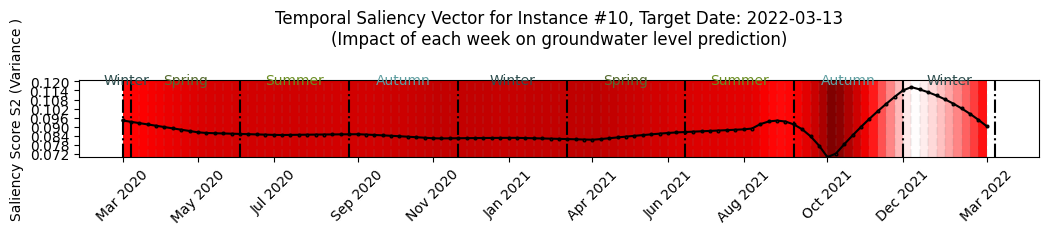

In [285]:
plot_saliency_vector(result_rise_temporal["saliency_vectors"][sample][1], vottignasco_test_dates, vottignasco_test_image_dates, sample, reverse_cbar=True, mode = "standard", ylab = "Saliency Score S2 (Variance )")

/scratch_local/ipykernel_4045930/1027572974.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


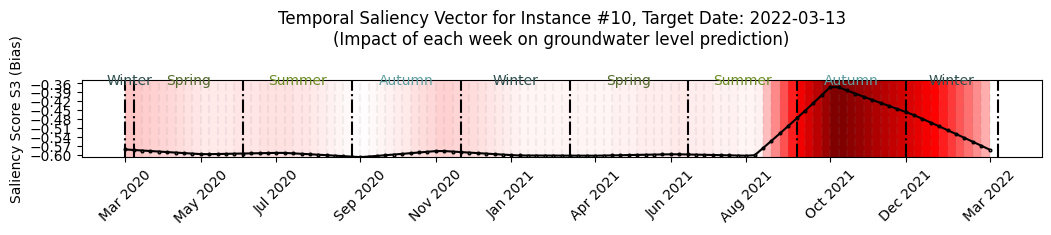

In [278]:
plot_saliency_vector(result_rise_temporal["saliency_vectors"][sample][2], vottignasco_test_dates, vottignasco_test_image_dates, sample, reverse_cbar=False, mode = "standard", ylab = "Saliency Score S3 (Bias)")

/scratch_local/ipykernel_4045930/1027572974.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


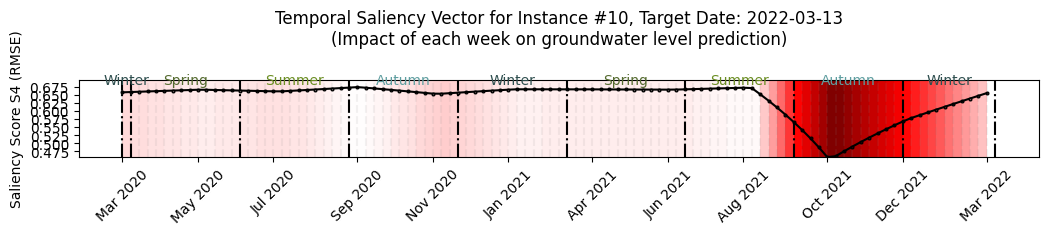

In [279]:
plot_saliency_vector(result_rise_temporal["saliency_vectors"][sample][3], vottignasco_test_dates, vottignasco_test_image_dates, sample, reverse_cbar=True, mode = "standard", ylab = "Saliency Score S4 (RMSE)")

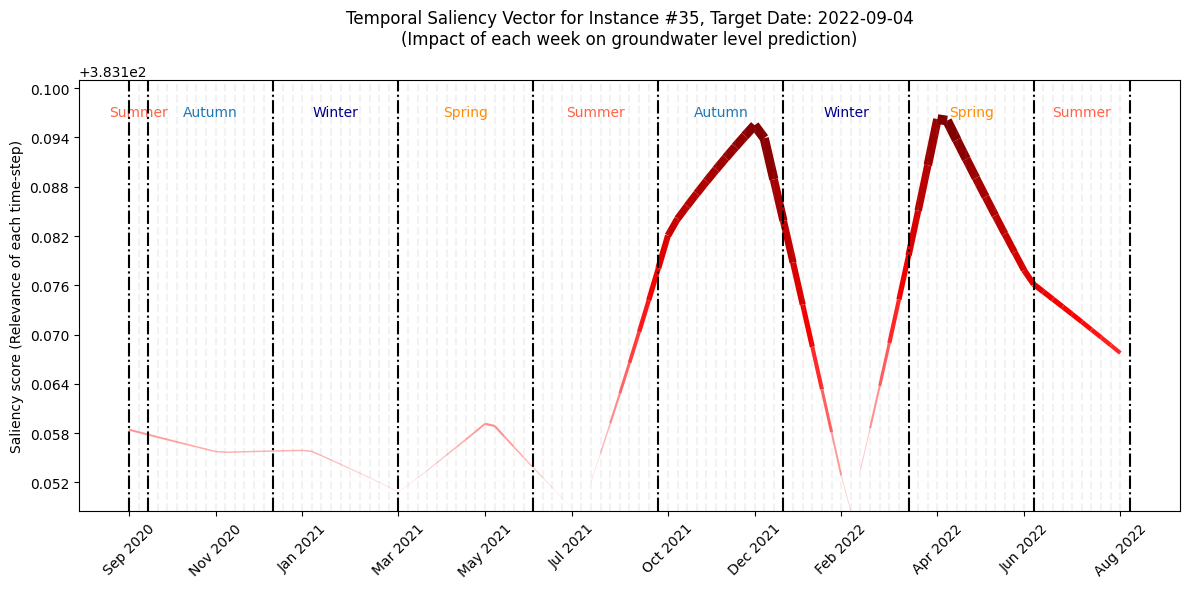

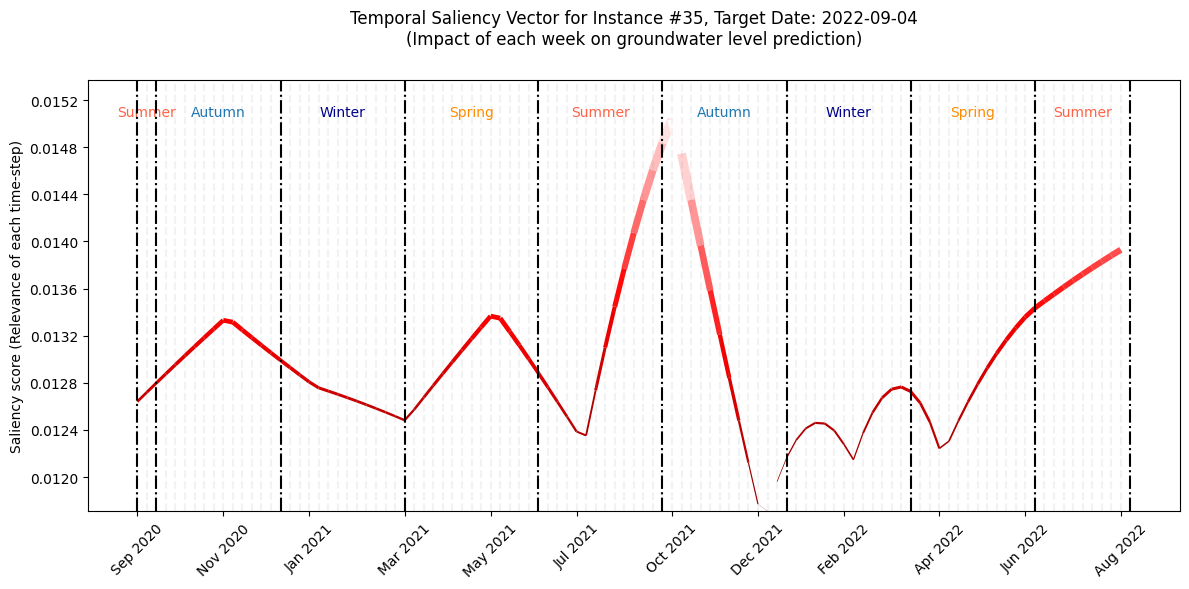

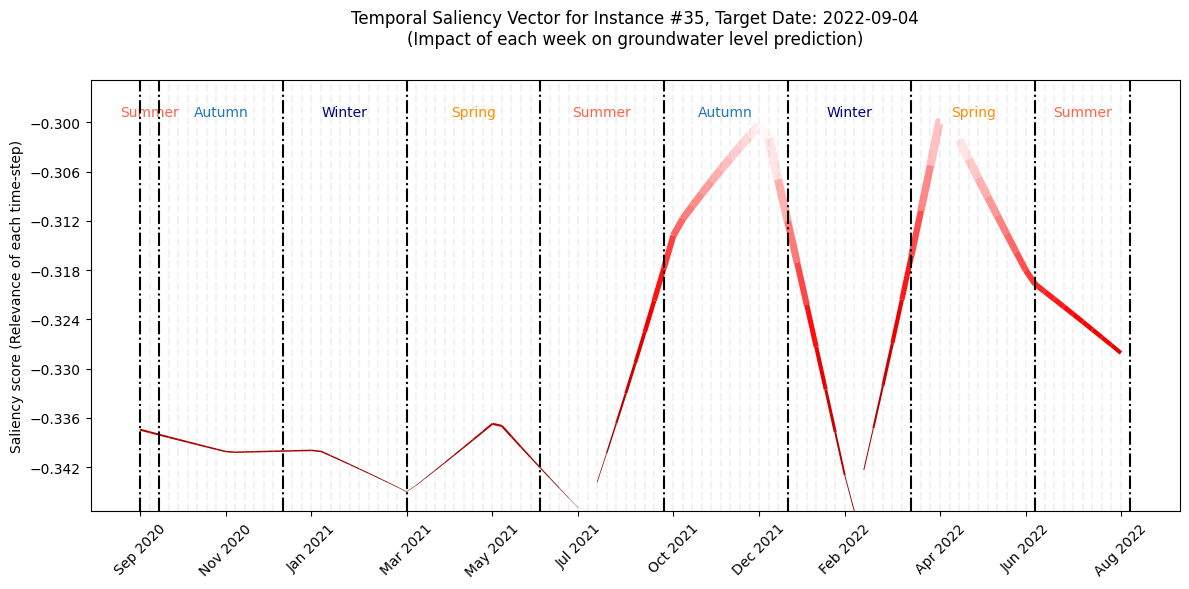

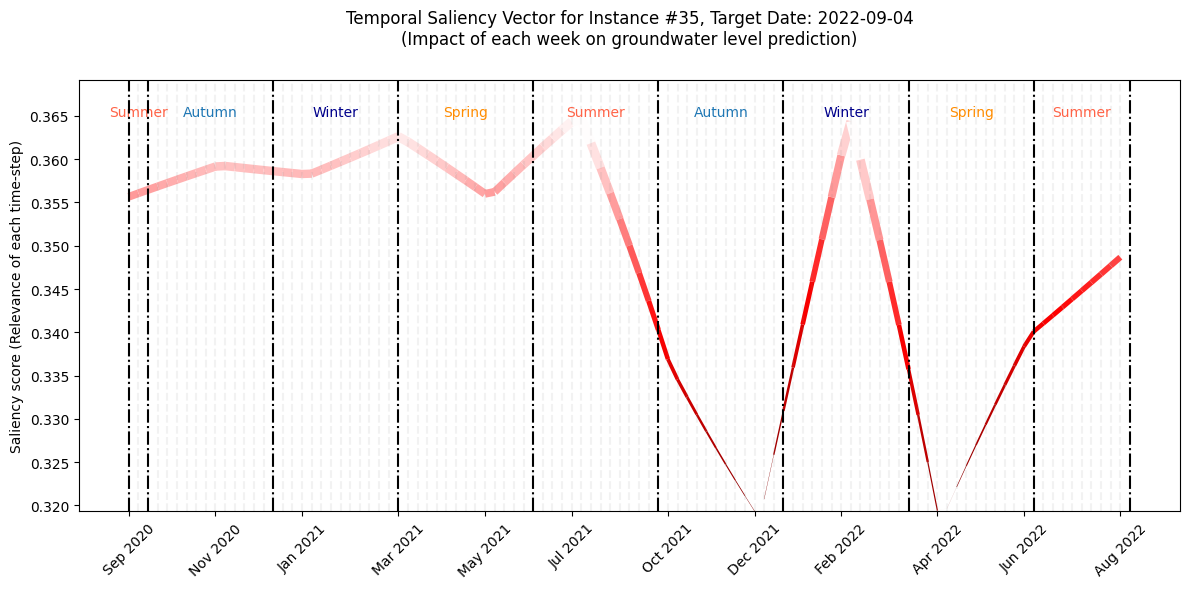

In [ ]:
nr_instance = 35
for index_i in range(4):
    s_i = result_rise_temporal["saliency_vectors"][nr_instance][index_i]

    if index_i in [1, 2, 3]:
        reverse_cbar = True
        if index_i in [1, 2, 3]:
            mode = "standard"
            bottom = 0
    else:S
        reverse_cbar = False
        mode = "standard"
        bottom = None

    plot_saliency_vector(s_i, vottignasco_test_dates, vottignasco_test_image_dates, nr_instance, reverse_cbar=reverse_cbar, mode = mode)